In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

WORKING_DIR = 'C:/term_project/'
os.chdir(WORKING_DIR)
print(os.getcwd())

C:\term_project


In [2]:
# IMPORTS & ENV VARS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

DATA_DIR = os.path.join(WORKING_DIR, 'data')
RESULT_DIR = os.path.join(WORKING_DIR, 'results')

LAG_WEEKS = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40]
ROLLING_WEEKS = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40]
DELTA_WEEKS = [1, 2, 3, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40]

XGB_PARAM_GRID = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

In [3]:
# LOAD TRAIN DATA

train_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_train.csv'), index_col=[0, 1, 2])
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'dengue_labels_train.csv'), index_col=[0, 1, 2])

# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

print("San Juan")
print("features: ", sj_train_features.shape)
print("labels  : ", sj_train_labels.shape)

print("\nIquitos")
print("features: ", iq_train_features.shape)
print("labels  : ", iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [4]:
print("San Juan Features:", sj_train_features.columns.tolist())
print("San Juan Labels:", sj_train_labels.columns.tolist())

San Juan Features: ['week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']
San Juan Labels: ['total_cases']


In [5]:
# PREPROCESS DATA 

def preprocess_city_data(features, labels=None):
    """
    Merges features and labels, converts week_start_date to index,
    and handles missing values.
    """
    # 1. Merge features and labels if labels are provided
    if labels is not None:
        df = features.join(labels)
    else:
        df = features.copy()
    
    # 2. Reset index to move 'year' and 'weekofyear' from index to columns
    # This preserves them as features.
    df.reset_index(inplace=True)
    
    # 3. Convert week_start_date to datetime
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    
    # 4. Set week_start_date as index
    df.set_index('week_start_date', inplace=True)
    
    # 5. Drop 'city' column as it's constant for each model and not numeric
    if 'city' in df.columns:
        df.drop(columns=['city'], inplace=True)
    
    # 6. Fill Missing Values (Forward Fill for time series)
    df = df.ffill()
    
    return df

# Apply to San Juan and Iquitos
sj_train = preprocess_city_data(sj_train_features, sj_train_labels)
iq_train = preprocess_city_data(iq_train_features, iq_train_labels)

print("San Juan Preprocessed Shape:", sj_train.shape)
print("Iquitos Preprocessed Shape:", iq_train.shape)
sj_train.head()

San Juan Preprocessed Shape: (936, 23)
Iquitos Preprocessed Shape: (520, 23)


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [6]:
# FEATURE EXTRACTION

def create_features(df, lag_weeks=LAG_WEEKS, rolling_weeks=ROLLING_WEEKS, delta_weeks=DELTA_WEEKS):
    """
    Creates lag and rolling window features.
    """
    df_eng = df.copy()
    
    # List of columns to create features for (exclude labels and non-numeric if any)
    # Typically climate variables
    feature_cols = [c for c in df.columns if c not in ['total_cases', 'year', 'weekofyear']]
    
    new_features = []
    
    for col in feature_cols:
        # Lag features
        for lag in lag_weeks:
            new_features.append(
                df_eng[col].shift(lag).rename(f'{col}_lag_{lag}')
            )

        # Delta features
        for delta in delta_weeks:
            new_features.append(
                (df_eng[col] - df_eng[col].shift(delta)).rename(f'{col}_delta_{delta}')
            )
            
        # Rolling features
        for window in rolling_weeks:
            rolling_col = df_eng[col].rolling(window=window)
            
            new_features.append(rolling_col.mean().rename(f'{col}_rolling_mean_{window}'))
            new_features.append(rolling_col.std().rename(f'{col}_rolling_std_{window}'))
            new_features.append(rolling_col.var().rename(f'{col}_rolling_var_{window}'))
            new_features.append(rolling_col.min().rename(f'{col}_rolling_min_{window}'))
            new_features.append(rolling_col.max().rename(f'{col}_rolling_max_{window}'))
            new_features.append(rolling_col.median().rename(f'{col}_rolling_median_{window}'))
            new_features.append(rolling_col.skew().rename(f'{col}_rolling_skew_{window}'))
            new_features.append(rolling_col.kurt().rename(f'{col}_rolling_kurt_{window}'))
            
    # Concatenate all new features at once to avoid PerformanceWarning (fragmentation)
    if new_features:
        df_features = pd.concat(new_features, axis=1)
        df_eng = pd.concat([df_eng, df_features], axis=1)
            
    # Drop rows with NaNs created by lag/rolling (or fill them)
    # For training, we usually drop the initial rows.
    df_eng.dropna(inplace=True)
    
    return df_eng

# Create engineered features
sj_train_eng = create_features(sj_train)
iq_train_eng = create_features(iq_train)

print("San Juan Engineered Shape:", sj_train_eng.shape)
print("Iquitos Engineered Shape:", iq_train_eng.shape)

San Juan Engineered Shape: (896, 2083)
Iquitos Engineered Shape: (480, 2083)


In [7]:
sj_train_eng

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,station_precip_mm_rolling_skew_36,station_precip_mm_rolling_kurt_36,station_precip_mm_rolling_mean_40,station_precip_mm_rolling_std_40,station_precip_mm_rolling_var_40,station_precip_mm_rolling_min_40,station_precip_mm_rolling_max_40,station_precip_mm_rolling_median_40,station_precip_mm_rolling_skew_40,station_precip_mm_rolling_kurt_40
week_start_date,,,,,,,,,,,,,,,,,,,,,
1991-02-05,1991,6,0.38010,0.228567,0.255043,0.225800,0.00,297.740000,297.928571,293.150000,...,1.338100,1.432342,23.7300,21.407490,458.280615,1.1,91.5,16.15,1.357724,1.518373
1991-02-12,1991,7,0.07120,0.221100,0.276243,0.267343,18.05,296.884286,297.114286,292.972857,...,1.429405,1.634767,23.6550,21.467028,460.833308,1.1,91.5,16.15,1.350682,1.494410
1991-02-19,1991,8,0.07120,0.209400,0.108433,0.119400,0.00,297.414286,297.614286,293.631429,...,1.476670,1.735295,23.0650,21.290404,453.281308,1.1,91.5,16.15,1.455923,1.812858
1991-02-26,1991,9,0.17020,0.208600,0.137520,0.191433,31.79,297.505714,297.828571,293.407143,...,1.433203,1.629668,23.7325,21.095004,444.999173,1.1,91.5,17.15,1.418003,1.777565
1991-03-05,1991,10,0.21075,0.264100,0.247686,0.216357,0.00,297.777143,298.078571,293.531429,...,1.448624,1.626962,23.8600,20.999033,440.959385,1.1,91.5,17.15,1.429009,1.819569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-25,2008,13,0.07785,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,...,1.185566,0.485632,28.7050,27.982641,783.028179,0.5,108.2,18.70,1.318821,0.897265
2008-04-01,2008,14,-0.03800,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,...,1.334788,0.985498,28.6800,28.008004,784.448308,0.5,108.2,18.70,1.315231,0.891613
2008-04-08,2008,15,-0.15520,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,...,1.302417,0.950013,29.0150,27.948474,781.117205,0.5,108.2,20.70,1.287632,0.856736


In [8]:
# DROP TIME FEATURES "year", "week_of_year"

sj_train_eng = sj_train_eng.drop(columns=["year", "weekofyear"])
iq_train_eng = iq_train_eng.drop(columns=["year", "weekofyear"])

print("San Juan Final: ", sj_train_eng.shape)
print("Iquitos Final: ", iq_train_eng.shape)

San Juan Final:  (896, 2081)
Iquitos Final:  (480, 2081)


In [9]:
# SPLIT DATA

def split_data(df, target_col='total_cases', train_ratio=0.7, val_ratio=0.15):
    """
    Splits data into X and y, and then into train, validation, and test sets (time-based).
    """
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    X_train = X.iloc[:train_end]
    y_train = y.iloc[:train_end]
    
    X_val = X.iloc[train_end:val_end]
    y_val = y.iloc[train_end:val_end]
    
    X_test = X.iloc[val_end:]
    y_test = y.iloc[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Split San Juan
X_train_sj, y_train_sj, X_val_sj, y_val_sj, X_test_sj, y_test_sj = split_data(sj_train_eng)

# Split Iquitos
X_train_iq, y_train_iq, X_val_iq, y_val_iq, X_test_iq, y_test_iq = split_data(iq_train_eng)

print("San Juan Shapes (Train/Val/Test):", X_train_sj.shape, X_val_sj.shape, X_test_sj.shape)
print("Iquitos Shapes (Train/Val/Test):", X_train_iq.shape, X_val_iq.shape, X_test_iq.shape)

San Juan Shapes (Train/Val/Test): (627, 2080) (134, 2080) (135, 2080)
Iquitos Shapes (Train/Val/Test): (336, 2080) (72, 2080) (72, 2080)


In [10]:
# HYPERPARAMETER TUNING WITH GRID SEARCH (VALIDATION SET)
from sklearn.model_selection import ParameterGrid

def tune_xgboost(X_train, y_train, X_val, y_val):
    """
    Performs Grid Search by training on Train and evaluating on Validation set.
    """
    # Define parameter grid
    param_grid = list(ParameterGrid(XGB_PARAM_GRID))
    
    best_score = float('inf')
    best_params = None
    best_model = None
    
    print(f"Tuning on {len(param_grid)} combinations...")
    
    for params in param_grid:
        # Add fixed params
        current_params = params.copy()
        current_params.update({
            'objective': 'reg:squarederror',
            'random_state': 42,
            'n_jobs': -1
        })
        
        model = xgb.XGBRegressor(**current_params)
        model.fit(X_train, y_train, verbose=False)
        
        preds = model.predict(X_val)
        preds = np.maximum(preds, 0)
        mae = mean_absolute_error(y_val, preds)
        
        if mae < best_score:
            best_score = mae
            best_params = params
            best_model = model
            
    print("Best Parameters:", best_params)
    print("Best MAE (Validation):", best_score)
    
    return best_model

# Tune San Juan
print("Tuning San Juan Model...")
best_model_sj = tune_xgboost(X_train_sj, y_train_sj, X_val_sj, y_val_sj)

# Tune Iquitos
print("\nTuning Iquitos Model...")
best_model_iq = tune_xgboost(X_train_iq, y_train_iq, X_val_iq, y_val_iq)

Tuning San Juan Model...
Tuning on 72 combinations...
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Best MAE (Validation): 14.733378410339355

Tuning Iquitos Model...
Tuning on 72 combinations...
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best MAE (Validation): 10.52680492401123


San Juan Tuned MAE: 18.3496
Iquitos Tuned MAE: 4.4198


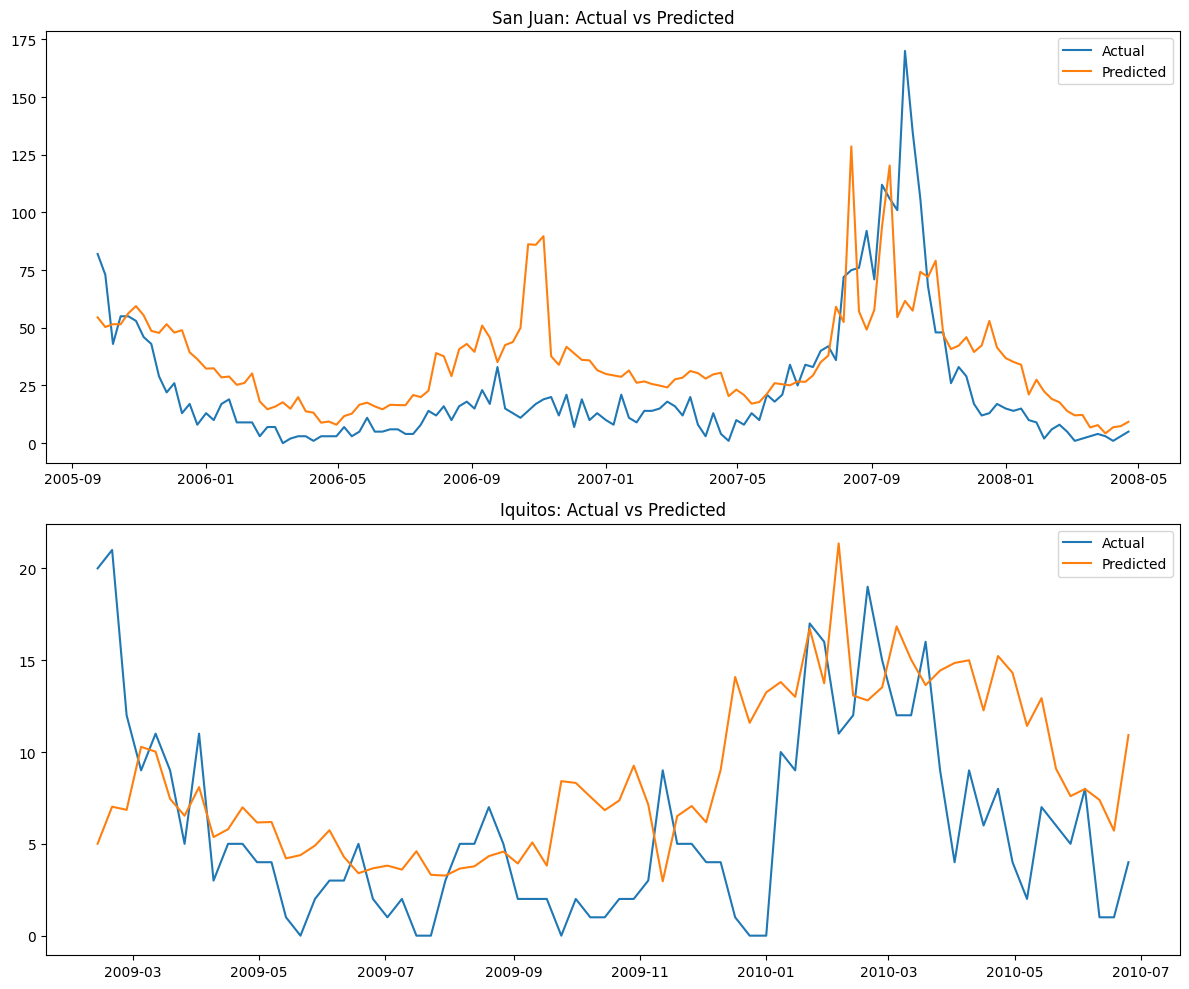

In [11]:
# EVALUATION AND VISUALIZATION

# Evaluate Tuned San Juan
preds_sj_tuned = best_model_sj.predict(X_test_sj)
preds_sj_tuned = np.maximum(preds_sj_tuned, 0)
mae_sj_tuned = mean_absolute_error(y_test_sj, preds_sj_tuned)
print(f"San Juan Tuned MAE: {mae_sj_tuned:.4f}")

# Evaluate Tuned Iquitos
preds_iq_tuned = best_model_iq.predict(X_test_iq)
preds_iq_tuned = np.maximum(preds_iq_tuned, 0)
mae_iq_tuned = mean_absolute_error(y_test_iq, preds_iq_tuned)
print(f"Iquitos Tuned MAE: {mae_iq_tuned:.4f}")

# Plot Results
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# San Juan
ax[0].plot(y_test_sj.index, y_test_sj, label='Actual')
ax[0].plot(y_test_sj.index, preds_sj_tuned, label='Predicted')
ax[0].set_title('San Juan: Actual vs Predicted')
ax[0].legend()

# Iquitos
ax[1].plot(y_test_iq.index, y_test_iq, label='Actual')
ax[1].plot(y_test_iq.index, preds_iq_tuned, label='Predicted')
ax[1].set_title('Iquitos: Actual vs Predicted')
ax[1].legend()

plt.tight_layout()
plt.show()

In [12]:
# PRINT FEATURE IMPORTANCES

print("\nSan Juan Feature Importances:")
importances_sj = pd.Series(best_model_sj.feature_importances_, index=X_train_sj.columns)
importances_sj = importances_sj.sort_values(ascending=False)  
print(importances_sj.head(20))

print("\nIquitos Feature Importances:")
importances_iq = pd.Series(best_model_iq.feature_importances_, index=X_train_iq.columns)
importances_iq = importances_iq.sort_values(ascending=False)    
print(importances_iq.head(20))

print("\nIntersection of Top 20 Features:")
top_20_sj = set(importances_sj.head(20).index)
top_20_iq = set(importances_iq.head(20).index)  
common_features = top_20_sj.intersection(top_20_iq)
print(common_features)


San Juan Feature Importances:
ndvi_se_rolling_max_4                         0.122117
ndvi_se_rolling_std_4                         0.093840
ndvi_se_rolling_median_4                      0.068380
ndvi_nw_rolling_std_20                        0.057082
ndvi_se_rolling_std_8                         0.043267
precipitation_amt_mm_rolling_max_20           0.043006
ndvi_nw_rolling_std_4                         0.038535
precipitation_amt_mm_rolling_std_20           0.037203
ndvi_ne_rolling_std_28                        0.027615
station_diur_temp_rng_c_rolling_skew_40       0.026656
ndvi_ne_rolling_kurt_24                       0.024643
station_min_temp_c_rolling_median_28          0.023372
station_min_temp_c_rolling_min_8              0.022489
ndvi_ne_rolling_median_12                     0.022427
reanalysis_tdtr_k_rolling_skew_24             0.021829
station_diur_temp_rng_c_rolling_skew_36       0.018140
station_diur_temp_rng_c_rolling_std_24        0.017901
reanalysis_dew_point_temp_k_rollin

In [13]:
# FINAL PREDICTIONS ON TEST SET AND SUBMISSION

# 1. Load Test Data
test_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_test.csv'), index_col=[0, 1, 2])

sj_test_features = test_features.loc['sj']
iq_test_features = test_features.loc['iq']

# 2. Preprocess Test Data
sj_test = preprocess_city_data(sj_test_features)
iq_test = preprocess_city_data(iq_test_features)

# 3. Feature Engineering for Test Data (handling lags)
def prepare_test_features(train_df, test_df, rolling_weeks=ROLLING_WEEKS, lag_weeks=LAG_WEEKS, delta_weeks=DELTA_WEEKS):
    """
    Combines train tail with test to generate features without NaNs in test.
    """
    # Calculate required history
    # We need enough history to compute the largest lag, rolling window, or delta
    max_lookback = max(max(rolling_weeks), max(lag_weeks), max(delta_weeks)) + 50 # Buffer
    
    # Get last part of training data (features only)
    # Ensure we only take columns present in test (exclude target if present)
    train_subset = train_df[test_df.columns].tail(max_lookback)
    
    # Concatenate
    combined = pd.concat([train_subset, test_df])
    
    # Create features
    combined_eng = create_features(combined, lag_weeks=lag_weeks, rolling_weeks=rolling_weeks, delta_weeks=delta_weeks)
    
    # Drop time features if they were dropped in training
    if 'year' in combined_eng.columns:
        combined_eng = combined_eng.drop(columns=['year', 'weekofyear'], errors='ignore')

    # Slice back the test part
    # We use the index of test_df to slice. 
    test_eng = combined_eng.loc[test_df.index]
    
    return test_eng

print("Generating Test Features...")
sj_test_eng = prepare_test_features(sj_train, sj_test)
iq_test_eng = prepare_test_features(iq_train, iq_test)

# Align test features with training features
# We use the columns from the engineered training set
sj_features_kept = [c for c in sj_train_eng.columns if c != 'total_cases']
iq_features_kept = [c for c in iq_train_eng.columns if c != 'total_cases']

sj_test_eng = sj_test_eng[sj_features_kept]
iq_test_eng = iq_test_eng[iq_features_kept]

print("San Juan Test Shape:", sj_test_eng.shape)
print("Iquitos Test Shape:", iq_test_eng.shape)

# 4. Retrain on Full Data (Train + Val + Test splits)
# We use the best parameters found during tuning
print("\nRetraining San Juan Model on Full Data...")
final_model_sj = xgb.XGBRegressor(**best_model_sj.get_params())
final_model_sj.fit(sj_train_eng[sj_features_kept], sj_train_eng['total_cases'])

print("Retraining Iquitos Model on Full Data...")
final_model_iq = xgb.XGBRegressor(**best_model_iq.get_params())
final_model_iq.fit(iq_train_eng[iq_features_kept], iq_train_eng['total_cases'])

# 5. Predict
sj_preds_final = final_model_sj.predict(sj_test_eng)
sj_preds_final = np.maximum(sj_preds_final, 0).astype(int)

iq_preds_final = final_model_iq.predict(iq_test_eng)
iq_preds_final = np.maximum(iq_preds_final, 0).astype(int)

# 6. Create Submission
submission = pd.read_csv(os.path.join(DATA_DIR, "submission_format.csv"), index_col=[0, 1, 2])

# Assign values
submission.loc['sj', 'total_cases'] = sj_preds_final
submission.loc['iq', 'total_cases'] = iq_preds_final

# 7. Save
submission_path = os.path.join(WORKING_DIR, 'results', 'submission_xgboost_3.csv')
submission.to_csv(submission_path)
print(f"Submission saved to {submission_path}")
submission.head()

Generating Test Features...
San Juan Test Shape: (260, 2080)
Iquitos Test Shape: (156, 2080)

Retraining San Juan Model on Full Data...
Retraining Iquitos Model on Full Data...
Submission saved to C:/term_project/results\submission_xgboost_3.csv


total_cases
city year weekofyear             
sj   2008 18                    2
          19                    2
          20                   26
          21                   38
          22                    2